# pyPESTO: Getting started

This notebook takes you through the first steps to get started with [pyPESTO](https://github.com/ICB-DCM/pyPESTO).

<img src="https://github.com/ICB-DCM/pyPESTO/raw/main/doc/logo/logo_wordmark.png" width="40%" alt="pyPESTO logo"/>

pyPESTO is a python package for parameter inference, offering a unified interface to various optimization and sampling methods. 
pyPESTO is highly modular and customizable, e.g., with respect to objective function definition and employed inference algorithms.

In [37]:
import logging

import amici
import matplotlib as mpl
import numpy as np
import scipy as sp

import pypesto.optimize as optimize
import pypesto.petab
import pypesto.visualize as visualize

np.random.seed(1)

# increase image resolution
mpl.rcParams["figure.dpi"] = 300

## 1. Objective Definition

PyPESTO allows the definition of a custom objectives, as well as offers support for objectives defined in the [PEtab](https://github.com/PEtab-dev/PEtab) format.

### Custom Objective Definition

You can define an objective via a python function. Also providing an analytical gradient (and potentially also a Hessian) improves the performance of Gradient/Hessian-based optimizers. When accessing parameter uncertainties via profile-likelihoods/sampling, pyPESTO interprets the objective function as the negative-log-likelihood/negative-log-posterior.

In [38]:
# define objective function
def f(x: np.array):
    return x[0] ** 2 + x[1] ** 2


# define gradient
def grad(x: np.array):
    return 2 * x


# define objective
custom_objective = pypesto.Objective(fun=f, grad=grad)

Define lower and upper parameter bounds and create an optimization problem. 

In [39]:
# define optimization bounds
lb = np.array([-10, -10])
ub = np.array([10, 10])

# create problem
custom_problem = pypesto.Problem(objective=custom_objective, lb=lb, ub=ub)

Now choose an optimizer to perform the optimization. `minimize` uses multi-start optimization, meaning that the optimization is run `n_start` times from different initial values, in case the problem contains multiple local optima (which of course is not the case for this toy problem).

In [40]:
# choose optimizer
optimizer = optimize.ScipyOptimizer()

# do the optimization
result_custom_problem = optimize.minimize(
    problem=custom_problem, optimizer=optimizer, n_starts=10
)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 72.75it/s]


`result_custom_problem.optimize_result` now stores a list, that contains the results and metadata of the individual optimizer runs (ordered by function value).

In [41]:
# E.g., The best model fit was obtained by the following optimization run:
result_custom_problem.optimize_result.list[0]

{'id': '1',
 'x': array([0., 0.]),
 'fval': 0.0,
 'grad': array([0., 0.]),
 'hess': None,
 'res': None,
 'sres': None,
 'n_fval': 4,
 'n_grad': 4,
 'n_hess': 0,
 'n_res': 0,
 'n_sres': 0,
 'x0': array([-9.9977125 , -3.95334855]),
 'fval0': 115.58322004264032,
 'history': <pypesto.history.base.CountHistory at 0x13c79c830>,
 'exitflag': 0,
 'time': 0.0028617382049560547,
 'message': 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL',
 'optimizer': "<ScipyOptimizer method=L-BFGS-B options={'disp': False, 'maxfun': 1000}>",
 'free_indices': array([0, 1]),
 'inner_parameters': None,
 'spline_knots': None}

In [42]:
# Objective function values of the different optimizer runs:
result_custom_problem.optimize_result.get_for_key("fval")

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 3.056285312137946e-36,
 3.76158192263132e-36,
 6.018531076210112e-36,
 9.780112998841433e-36]

### Problem Definition via PEtab

#### Background on PEtab

<img src="https://github.com/PEtab-dev/PEtab/blob/main/doc/gfx/petab_files.png?raw=true" width="80%" alt="pyPESTO logo"/>

PyPESTO supports the [PEtab](https://github.com/PEtab-dev/PEtab) standard. PEtab is a data format for specifying parameter estimation problems in systems biology. 

A PEtab problem consist of an [SBML](https://sbml.org) file, defining the model topology and a set of `.tsv` files, defining experimental conditions, observables, measurements and parameters (and their optimization bounds, scale, priors...). All files that make up a PEtab problem can be structured in a `.yaml` file. The `pypesto.Objective` coming from a PEtab problem corresponds to the negative-log-likelihood/negative-log-posterior distribution of the parameters.  

For more details on PEtab, the interested reader is referred to [PEtab's format definition](https://petab.readthedocs.io/en/latest/documentation_data_format.html), for examples, the reader is referred to the [PEtab benchmark collection](https://github.com/Benchmarking-Initiative/Benchmark-Models-PEtab). The Model from _[Böhm et al. JProteomRes 2014](https://pubs.acs.org/doi/abs/10.1021/pr5006923)_ is part of the benchmark collection and will be used as the running example throughout this notebook.

PyPESTO provides an interface to the model simulation tool [AMICI](https://github.com/AMICI-dev/AMICI) for the simulation of Ordinary Differential Equation (ODE) models specified in the SBML format.

#### Basic Model Import and Optimization

The first step is to import a PEtab problem and create a `pypesto.problem` object:

In [43]:
%%capture
# directory of the PEtab problem
petab_yaml = "./conversion_reaction/conversion_reaction.yaml"

importer = pypesto.petab.PetabImporter.from_yaml(petab_yaml)
problem = importer.create_problem(verbose=False)

Next, we choose an `optimizer` to perform the multi start optimization.

In [44]:
%%time
%%capture

# choose optimizer
optimizer = optimize.ScipyOptimizer()

# do the optimization
result = optimize.minimize(problem=problem, optimizer=optimizer, n_starts=5)

CPU times: user 434 ms, sys: 38.5 ms, total: 472 ms
Wall time: 500 ms


`result.optimize_result` contains a list with the ordered optimization results.

In [45]:
# E.g., best model fit was obtained by the following optimization run:
result.optimize_result.list[0]

{'id': '3',
 'x': array([-0.25416791, -0.60834123]),
 'fval': -25.35620111196706,
 'grad': array([ 5.52602527e-05, -3.89021152e-05]),
 'hess': None,
 'res': None,
 'sres': None,
 'n_fval': 60,
 'n_grad': 60,
 'n_hess': 0,
 'n_res': 0,
 'n_sres': 0,
 'x0': array([ 4.42839188, -7.60243554]),
 'fval0': 3275.6428996850577,
 'history': <pypesto.history.base.CountHistory at 0x13c79cf20>,
 'exitflag': 2,
 'time': 0.23737597465515137,
 'message': 'ABNORMAL_TERMINATION_IN_LNSRCH',
 'optimizer': "<ScipyOptimizer method=L-BFGS-B options={'disp': False, 'maxfun': 1000}>",
 'free_indices': array([0, 1]),
 'inner_parameters': None,
 'spline_knots': None}

In [46]:
# Objective function values of the different optimizer runs:
result.optimize_result.get_for_key("fval")

[-25.35620111196706,
 49.9096545687522,
 132.61011287146394,
 132.61011287146414,
 3275.7137352431205]

## 2. Optimizer Choice

PyPESTO provides a unified interface to a variety of optimizers of different types:

* All [scipy optimizer](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize) (`optimize.ScipyOptimizer(method=<method_name>)`)
    * _function-value_ or _least-squares_-based optimizers
    * _gradient_ or _hessian_-based optimizers
* [IpOpt](https://pypi.org/project/ipopt/) (`optimize.IpoptOptimizer()`)
    * Interior point method
* [Dlib](http://dlib.net) (`optimize.DlibOptimizer(options={'maxiter': <max. number of iterations>})`)
    * Global optimizer
    * Gradient-free
* [FIDES](https://github.com/fides-dev/fides/) (`optimize.FidesOptimizer()`)
    * Interior Trust Region optimizer 
* [Particle Swarm](https://github.com/ljvmiranda921/pyswarms) (`optimize.PyswarmsOptimizer()`)
    * Particle swarm algorithm
    * Gradient-free
* [CMA-ES](https://pypi.org/project/cma-es/) (`optimize.CmaOptimizer()`)
    * Covariance Matrix Adaptation Evolution Strategy
    * Evolutionary Algorithm

In [47]:
optimizer_scipy_lbfgsb = optimize.ScipyOptimizer(method="L-BFGS-B")
optimizer_scipy_powell = optimize.ScipyOptimizer(method="Powell")

optimizer_fides = optimize.FidesOptimizer(verbose=logging.ERROR)
optimizer_pyswarm = optimize.PyswarmsOptimizer(par_popsize=10)

The following performs 10 multi-start runs with different optimizers in order to compare their performance. For a faster execution of this notebook, we run only 10 starts. In application, one would use many more optimization starts: around 100-1000 in most cases.

_Note_: `dlib` and `pyswarm` need to be installed for this section to run. Furthermore, the computation time is in the order of minutes, so you might want to skip the execution and jump to the section on large scale models.  

In [50]:
%%time
%%capture --no-display
n_starts = 10

# Due to run time we already use parallelization.
# This will be introduced in more detail later.
engine = pypesto.engine.MultiProcessEngine()

# Scipy: L-BFGS-B
result_lbfgsb = optimize.minimize(
    problem=problem,
    optimizer=optimizer_scipy_lbfgsb,
    engine=engine,
    n_starts=n_starts,
)

# Scipy: Powell
result_powell = optimize.minimize(
    problem=problem,
    optimizer=optimizer_scipy_powell,
    engine=engine,
    n_starts=n_starts,
)

# Fides
result_fides = optimize.minimize(
    problem=problem,
    optimizer=optimizer_fides,
    engine=engine,
    n_starts=n_starts,
)


# PySwarm
result_pyswarm = optimize.minimize(
    problem=problem,
    optimizer=optimizer_pyswarm,
    engine=engine,
    n_starts=1,  # Global optimizers are usually run once. The number of particles (par_popsize) is usually the parameter that is adapted.
)

Engine will use up to 8 processes (= CPU count).


CPU times: user 156 ms, sys: 217 ms, total: 374 ms
Wall time: 41.7 s


### Optimizer Convergence


A common visualization of optimizer convergence are waterfall plots. Waterfall plots show the (ordered) results of the individual optimization runs. In general, we hope to obtain clearly visible plateaus, as they indicate optimizer convergence to local minima. 

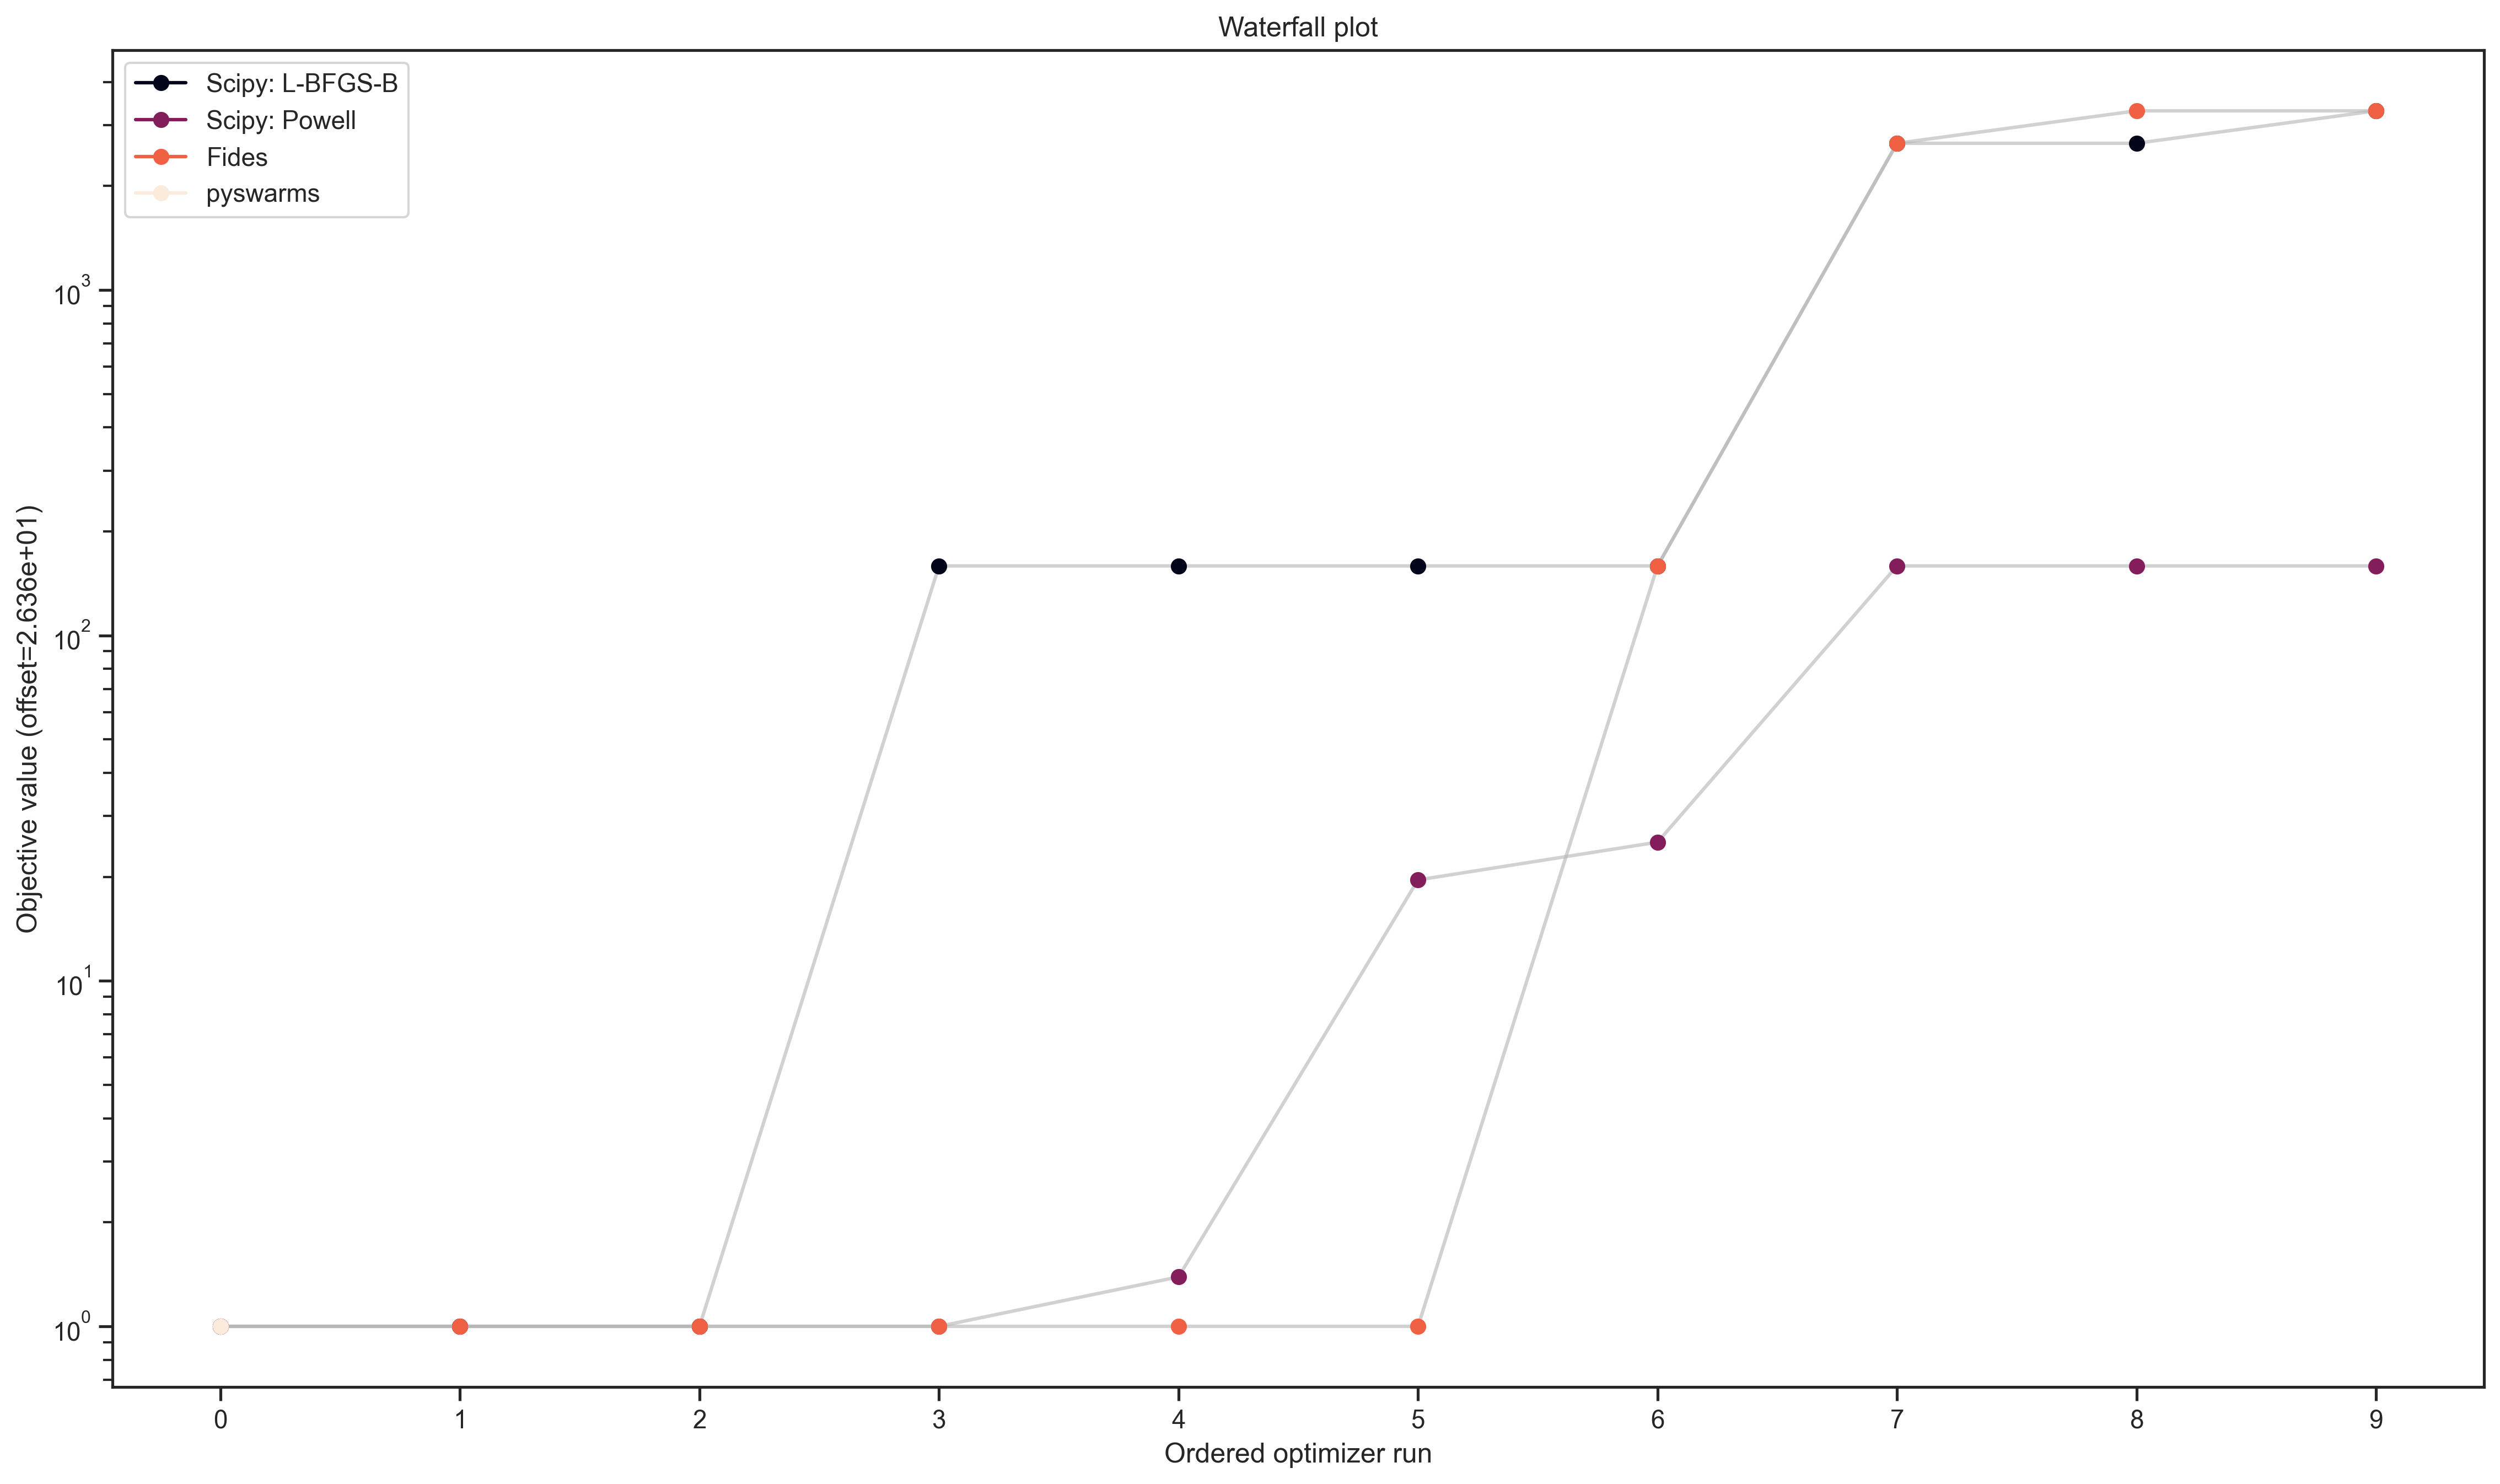

In [51]:
optimizer_results = [
    result_lbfgsb,
    result_powell,
    result_fides,
    result_pyswarm,
]
optimizer_names = ["Scipy: L-BFGS-B", "Scipy: Powell", "Fides", "pyswarms"]

pypesto.visualize.waterfall(optimizer_results, legends=optimizer_names);

### Optimizer run time

Optimizer run time vastly differs among the different optimizers, as can be seen below:

In [ ]:
print("Average Run time per start:")
print("-------------------")

for optimizer_name, optimizer_result in zip(
    optimizer_names, optimizer_results
):
    t = np.sum(optimizer_result.optimize_result.get_for_key("time")) / n_starts
    print(f"{optimizer_name}: {t:f} s")

## 3. Fitting of large scale models

When fitting large scale models (i.e. with >100 parameters and accordingly also more data), two important issues are efficient gradient computation and parallelization.

### Efficient gradient computation

As seen in the example above and as can be confirmed from own experience: If fast and reliable gradients can be provided, gradient-based optimizers are favourable with respect to optimizer convergence and run time.  

It has been shown that adjoint sensitivity analysis is a fast and reliable method to compute gradients for large scale models, since their run time is (asymptotically) independent of the number of parameters ([Fröhlich et al. PlosCB 2017](https://journals.plos.org/ploscompbiol/article/file?id=10.1371/journal.pcbi.1005331&type=printable)).

<img src="https://journals.plos.org/ploscompbiol/article/figure/image?size=large&id=10.1371/journal.pcbi.1005331.g002" width="40%" alt="pyPESTO logo"/> 

(Figure from Fröhlich et al. PlosCB 2017) Adjoint sensitivities are implemented in AMICI.

In [ ]:
# Set gradient computation method to adjoint
problem.objective.amici_solver.setSensitivityMethod(
    amici.SensitivityMethod.adjoint
)

### Parallelization

Multi-start optimization can easily be parallelized by using `engines`.

In [ ]:
%%time
%%capture

# Parallelize
engine = pypesto.engine.MultiProcessEngine()

# Optimize
result = optimize.minimize(
    problem=problem,
    optimizer=optimizer_scipy_lbfgsb,
    engine=engine,
    n_starts=25,
)

## 4. Uncertainty quantification

PyPESTO focuses on two approaches to assess parameter uncertainties:

* Profile likelihoods
* Sampling

### Profile Likelihoods

[Profile likelihoods](https://academic.oup.com/bioinformatics/article/25/15/1923/213246) compute confidence intervals via a [likelihood ratio test](https://en.wikipedia.org/wiki/Likelihood-ratio_test). Profile likelihoods perform a maximum-projection of the likelihood function on the parameter of interest. The likelihood ratio test then gives a cut-off criterion via the $\chi^2_1$ distribution.

In pyPESTO, the maximum projection is solved as a maximization problem and can be obtained via

In [ ]:
%%time
%%capture

import pypesto.profile as profile

result = profile.parameter_profile(
    problem=problem,
    result=result,
    optimizer=optimizer_scipy_lbfgsb,
    profile_index=[0, 1],
)

The maximum projections can now be inspected via:

In [ ]:
# adapt x_labels..
x_labels = [f"Log10({name})" for name in problem.x_names]

visualize.profiles(result, x_labels=x_labels, show_bounds=True);

The plot shows that seven parameters are identifiable, since the likelihood is tightly centered around the optimal parameter. Two parameters (`k_exp_hetero` and `k_imp_homo`) cannot be constrained by the data.

Furthermore pyPESTO allows to visualize confidence intervals directly via

In [ ]:
ax = pypesto.visualize.profile_cis(
    result, confidence_level=0.95, show_bounds=True
)

ax.set_xlabel("Log10(Parameter value)");

### Sampling

In pyPESTO, sampling from the posterior distribution can be performed as 

In [ ]:
import pypesto.sample as sample

n_samples = 1000

sampler = sample.AdaptiveMetropolisSampler()

result = sample.sample(
    problem, n_samples=n_samples, sampler=sampler, result=result
)

Sampling results are stored in `result.sample_result` and can be accessed e.g., via

In [ ]:
result.sample_result["trace_x"]

### Sampling Diagnostics

Geweke's test assesses convergence of a sampling run and computes the burn-in of a sampling result. The effective sample size indicates the strength of the correlation between different samples.

In [ ]:
sample.geweke_test(result=result)
result.sample_result["burn_in"]

In [ ]:
sample.effective_sample_size(result=result)
result.sample_result["effective_sample_size"]

### Visualization of Sampling Results

In [ ]:
# scatter plots
visualize.sampling_scatter(result)

# marginals
visualize.sampling_1d_marginals(result);

#### Sampler Choice:

Similarly to parameter optimization, pyPESTO provides a unified interface to several sampler/sampling toolboxes, as well as own implementations of sampler:

* Adaptive Metropolis:   `sample.AdaptiveMetropolisSampler()`
* Adaptive parallel tempering:   `sample.ParallelTemperingSampler()`
* Interface to `pymc3` via `sample.Pymc3Sampler()`

## 5. Storage

You can store and load the results of an analysis via the `pypesto.store` module to a `.hdf5` file.

### Store result

In [ ]:
import tempfile

import pypesto.store as store

# create a temporary file, for demonstration purpose
f_tmp = tempfile.NamedTemporaryFile(suffix=".hdf5", delete=False)
result_file_name = f_tmp.name

# store the result
store.write_result(result, result_file_name)
f_tmp.close()

### Load result file

You can re-load a result, e.g. for visualizations:

In [ ]:
# read result
result_loaded = store.read_result(result_file_name)

# e.g. do some visualisation
visualize.waterfall(result_loaded);

## Software Development Standards:

PyPESTO is developed with the following standards:

* **Open source**, code on [GitHub](https://github.com/ICB-DCM/pyPESTO).
* [**Pip installable**](https://pypi.org/project/pypesto/) via: `pip install pypesto`.
* **Documentation** as [RTD](https://pypesto.readthedocs.io/en/stable/) and [example **jupyter notebooks**](https://github.com/ICB-DCM/pyPESTO/tree/master/doc/example) are available.
* Has **continuous integration** & extensive automated **testing**.
* **Code reviews** before merging into the develop/main branch.

* Currently, **5–10 people are using, extending** and (most importantly) **maintaining** pyPESTO in their "daily business".

## Further topics

Further features are available, among them:

* Model Selection
* Hierarchical Optimization of scaling/noise parameters
* Categorical Data